In [ ]:
import pandas as pd
import numpy as np

import os
import random
import cv2

import numpy as np
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import time
# !pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout

from keras.layers import Conv1D, Flatten,MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc

# Regular Expression for text cleaning
import re
# to track the progress - progress bar
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load already cleaned text.

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/cleaned_NewsHeadlines_comments.csv").dropna()
df

,is_sarcastic,headline,article_link
0,1,thirtysomethe scientist unveil doomsday clock ...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep totally nail why congress be fall shor...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggie 9 deliciously different recipe,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevent liar get to work,https://local.theonion.com/inclement-weather-p...
4,1,mother come pretty close to use word streaming...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappoint consp...,https://local.theonion.com/internal-affairs-in...
28616,0,most beautiful acceptance speech this week com...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroy by orbit spielberg gates sp...,https://www.theonion.com/mars-probe-destroyed-...


# Dataset split
Training/Validation/Test : 80/10/10

Constant seed = 42

In [ ]:
from collections import Counter
import numpy as np

all_words = ' '.join(df['headline']).split()
word_counts = Counter(all_words)

total_tokens = sum(word_counts.values())
sorted_counts = np.array(sorted(word_counts.values(), reverse=True))
cumulative = np.cumsum(sorted_counts) / total_tokens

# For example, find how many words cover 95% of the corpus
vocab_95 = np.argmax(cumulative >= 0.95) + 1
print("Words needed for 95% coverage:", vocab_95)


Words needed for 95% coverage: 9764


In [ ]:
# total unique words we are going to use.
VOCAB_SIZE = 10000

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(list(df['headline']))

strat = df['is_sarcastic']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42, stratify= strat)
strat = dummy_df['is_sarcastic']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42, stratify= strat)

print('Total dataset is ', df.shape)
print('Train shape is ' , train_df.shape)
print('Valid shape is ' , valid_df.shape)
print('Test shape is ' , test_df.shape)


Total dataset is  (28619, 3)
Train shape is  (22895, 3)
Valid shape is  (2862, 3)
Test shape is  (2862, 3)


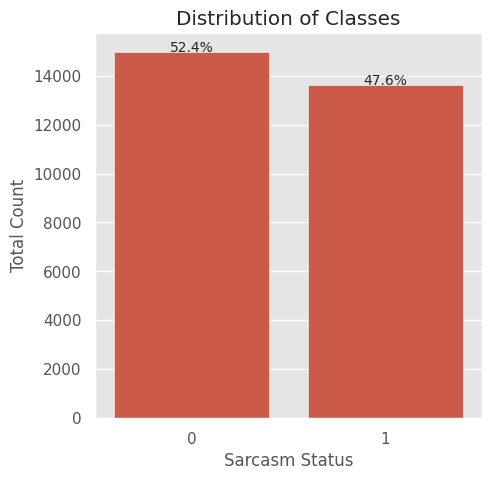

In [ ]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='is_sarcastic',  data= df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center")
plt.show()

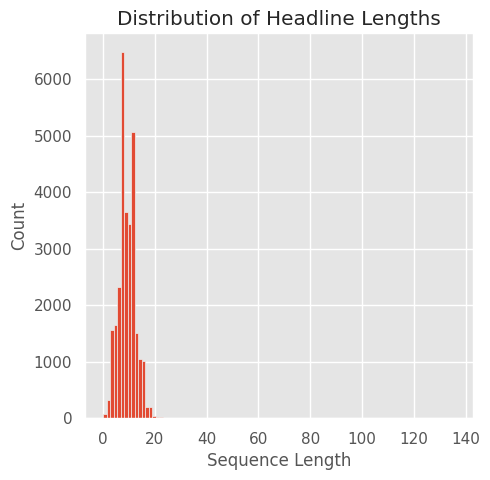

In [ ]:
import matplotlib.pyplot as plt

headline_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(df['headline'])]

plt.figure(figsize=(5, 5))
plt.hist(headline_lengths, bins=100)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Headline Lengths')
plt.show()


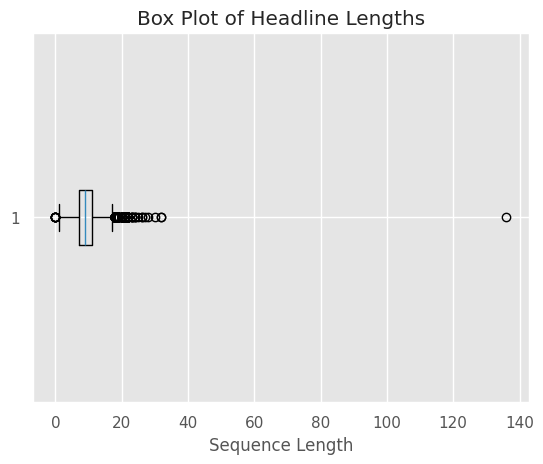

In [ ]:
import matplotlib.pyplot as plt

headline_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(df['headline'])]

plt.boxplot(headline_lengths, vert=False)
plt.xlabel('Sequence Length')
plt.title('Box Plot of Headline Lengths')
plt.show()

In [ ]:
import numpy as np

lengths = np.array(headline_lengths)
print("90th percentile:", np.percentile(lengths, 90))
print("95th percentile:", np.percentile(lengths, 95))
print("99th percentile:", np.percentile(lengths, 95))
print("Max:", np.max(lengths))


90th percentile: 14.0
95th percentile: 15.0
99th percentile: 15.0
Max: 146


In [ ]:
MAX_SEQUENCE_LENGTH = 15
# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['headline'])
X_valid = tokenizer.texts_to_sequences(valid_df['headline'])
X_test = tokenizer.texts_to_sequences(test_df['headline'])

# Pad sequences to ensure uniform length
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
X_valid = pad_sequences(X_valid, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')

# Convert labels to categorical (0 or 1)
y_train = np.array(train_df['is_sarcastic'])
y_valid = np.array(valid_df['is_sarcastic'])
y_test = np.array(test_df['is_sarcastic'])

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, SpatialDropout1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam

EMBEDDING_DIM = 128  # Word embedding size
LSTM_UNITS = 128
DROPOUT_RATE = 0.3

# Model definition
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(inputs)
x = SpatialDropout1D(0.2)(embedding)
x = LSTM(LSTM_UNITS, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)  # Extracts key features
x = Dense(64, activation='relu')(x)  # Fully connected layer
x = Dropout(DROPOUT_RATE)(x)  # Prevents overfitting
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs, outputs)



# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 15, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,419,905 (5.42 MB)

 Trainable params: 1,419,905 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

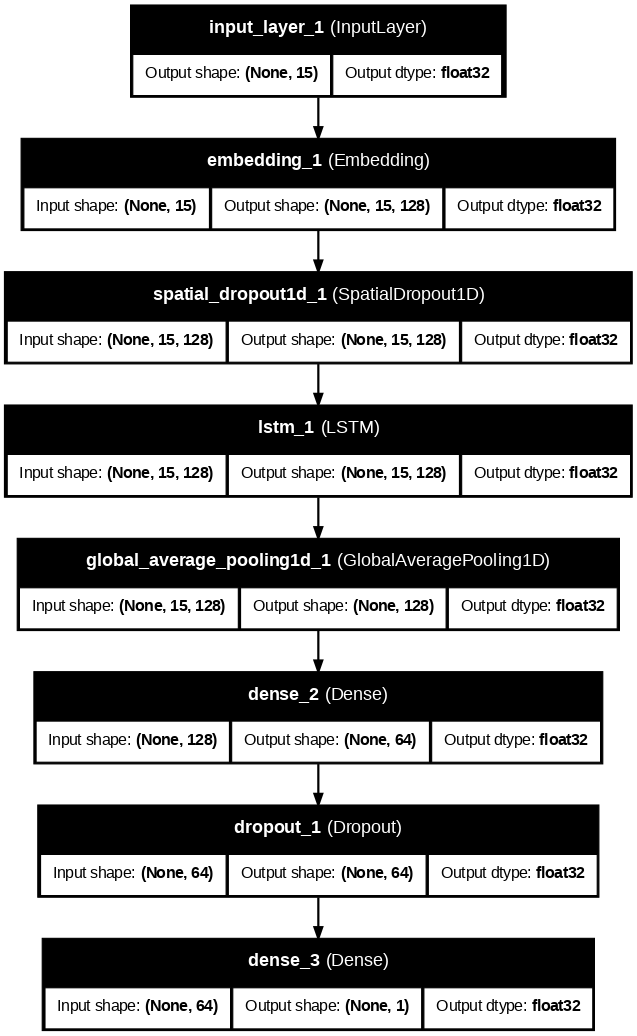

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [ ]:
from tensorflow.keras.callbacks import CSVLogger

# Define the CSVLogger callback
csv_logger = CSVLogger("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/Apr19_NewsHeadline_ngramPreprocessVer_LSTM.csv", append=True)  # Replace with desired path

# Add it to the callbacks list

# Define a checkpoint callback to save the best model

#save_weights_only=True in ModelCheckpoint, the filepath provided must end in .weights.h5 (Keras weights format)
# Set up ModelCheckpoint callback
def checkpoint_callback():
    checkpoint_filepath = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/Apr19_NewsHeadline_ngramPreprocessVer_LSTM.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                          #  save_weights_only=True,  # Save only the best weights
                           monitor='val_accuracy',
                           mode = 'max',          # 'max' because we are looking for max validation acc
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=1)
    return es_callback

early_stopping = early_stopping(patience=5)
checkpoint_callback = checkpoint_callback()
callbacks = [checkpoint_callback, early_stopping, csv_logger]

#Create the Adam optimizer with an initial learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5) # Use initial learning rate here
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
import pickle
hist = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)
# history_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/Apr19_NewsHeadline_ngramPreprocessVer_LSTM.pickle"
# with open(history_path, 'wb') as file_pi:
#     pickle.dump(hist.history, file_pi)

Epoch 1/30
716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5478 - loss: 0.6894
Epoch 1: val_accuracy improved from -inf to 0.67121, saving model to /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/Apr19_NewsHeadline_ngramPreprocessVer_LSTM.keras
716/716 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5478 - loss: 0.6894 - val_accuracy: 0.6712 - val_loss: 0.6419
Epoch 2/30
711/716 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7024 - loss: 0.5783
Epoch 2: val_accuracy improved from 0.67121 to 0.77393, saving model to /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_model/Apr19_NewsHeadline_ngramPreprocessVer_LSTM.keras
716/716 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7026 - loss: 0.5779 - val_accuracy: 0.7739 - val_loss: 0.4755
Epoch 3/30
715/716 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7966 - loss: 0.4317
Epoch 3: val_accuracy improved from 0.77393 to 0.78686, saving model to /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/LSTM_m

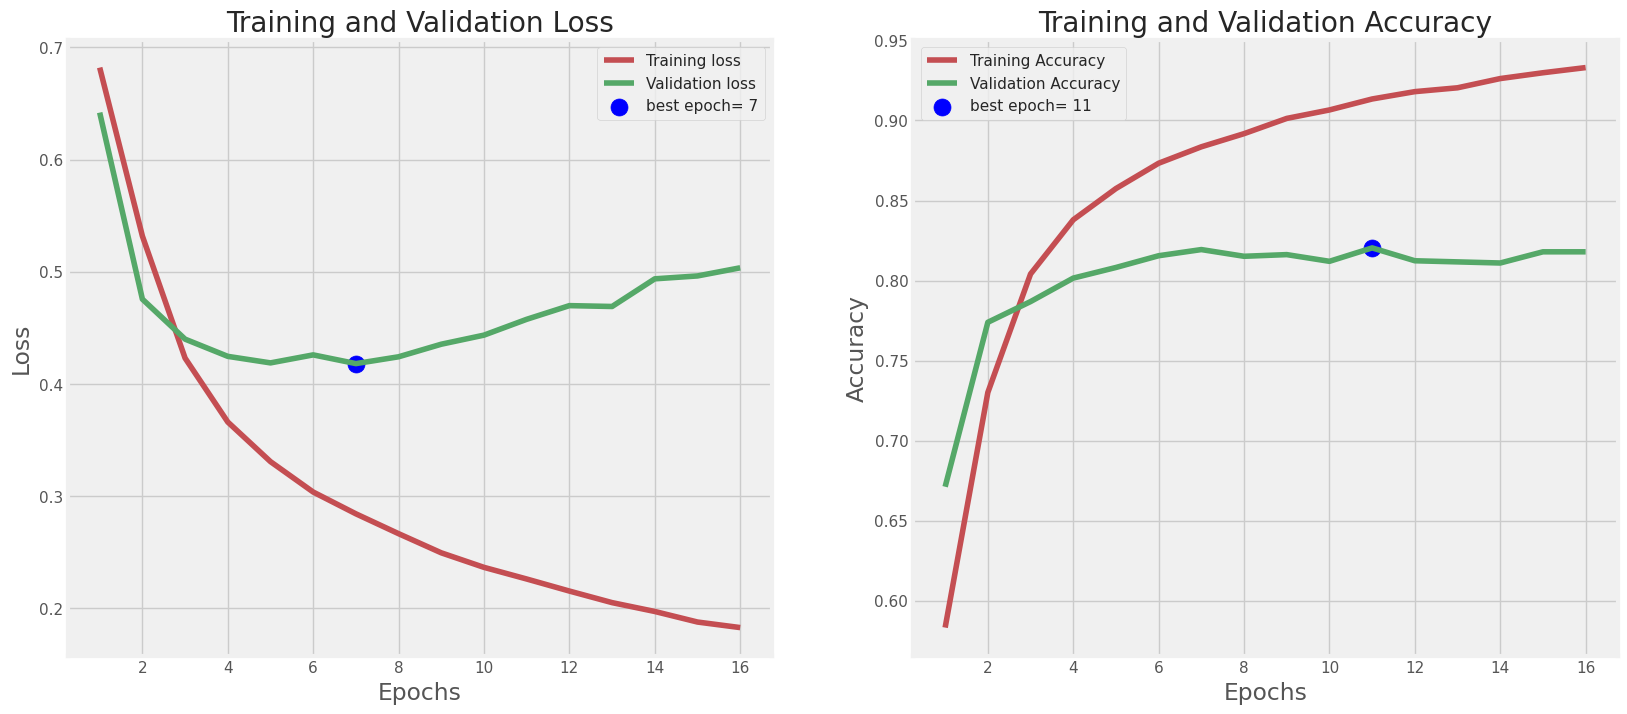

In [ ]:
# Function to get true and predicted labels from the dataset
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()
plot_training(hist)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

train_score = model.evaluate(X_train, y_train, verbose=1)
valid_score = model.evaluate(X_valid, y_valid, verbose=1)
test_score = model.evaluate(X_test, y_test, verbose=1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9303 - loss: 0.1907
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8261 - loss: 0.4539
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8333 - loss: 0.4233
Train Loss:  0.19228294491767883
Train Accuracy:  0.9302467703819275
--------------------
Validation Loss:  0.4575152099132538
Validation Accuracy:  0.8204053044319153
--------------------
Test Loss:  0.41966843605041504
Test Accuracy:  0.8312368988990784


In [ ]:
embedding_model = Model(inputs=model.input, outputs=model.get_layer('lstm_1').output)
X_test_embeddings = embedding_model.predict(X_test)

print("Shape of extracted embeddings:", X_test_embeddings.shape)  # (num_samples, LSTM_UNITS)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Shape of extracted embeddings: (2862, 15, 128)


In [ ]:
class_names = [str(i) for i in range(len(np.unique(y_test)))]
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int)
# Get the true class labels from the test data generator
# Check if y_test is one-hot encoded or class labels
if len(y_test.shape) == 2:
    y_true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
else:
    y_true_labels = y_test  # Already class labels


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


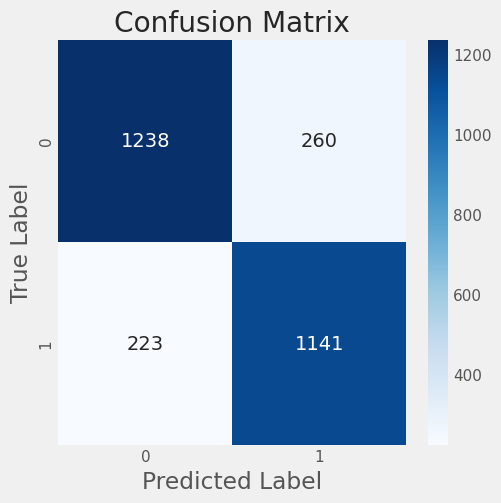

In [ ]:


# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, digits=4)


print("Classification Report: ")
print( report)

Classification Report: 
              precision    recall  f1-score   support

           0     0.8474    0.8264    0.8368      1498
           1     0.8144    0.8365    0.8253      1364

    accuracy                         0.8312      2862
   macro avg     0.8309    0.8315    0.8310      2862
weighted avg     0.8317    0.8312    0.8313      2862



90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


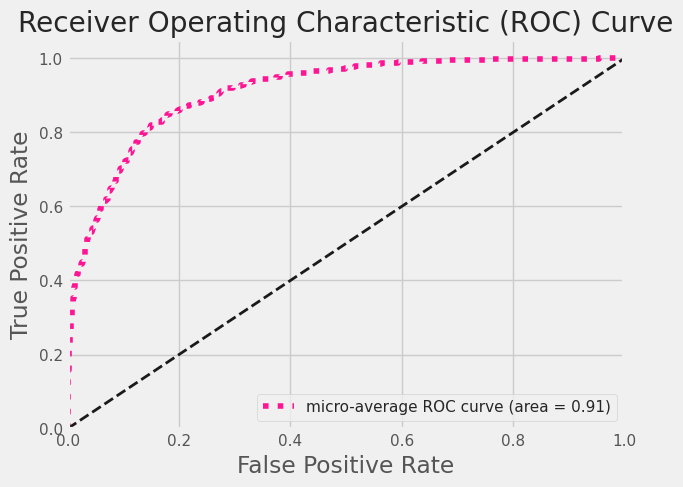

np.float64(0.9103354815217946)

In [ ]:
from tensorflow.keras import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Binarize the true labels for multi-class ROC calculation
y_true_bin = label_binarize(y_true_labels, classes=np.unique(y_true_labels))
n_classes = y_true_bin.shape[1]  # Number of classes

# Get prediction probabilities instead of predicted labels
y_pred_prob = model.predict(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the micro-average ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curves for each class (optional)
# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Get the micro-average AUC value
auc_value = roc_auc["micro"]  # Access the AUC value directly
auc_value